# Spam filter with Machine Learning

Text message SPAM filter with AI.

# Building a Text Message Spam Filter with a Naive Bayes Classifier

This tutorial explains how to classify text messages as SPAM / NOT SPAM using scikit-learn.

# data preparation

In [1]:
%pylab inline
messages=[]
categories=[]
y=[]
for line in open('smsdata.txt', encoding='utf8'):
    category, message= line.split('\t')
    messages.append(message)
    categories.append(category)
for item in categories:
    if item == 'ham': 
        y.append(0) #no spam
    else:
        y.append(1) # SPAM
print("0 means no spam")
print("1 means SPAM")

Populating the interactive namespace from numpy and matplotlib
0 means no spam
1 means SPAM


In [2]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, ENGLISH_STOP_WORDS
pattern='(?u)\\b[A-Za-z]{3,}'
stop_words= set(list(ENGLISH_STOP_WORDS)+ ['test'])

cv=CountVectorizer(token_pattern=pattern, stop_words=stop_words, ngram_range=(1,2))
C=cv.fit_transform(messages)
tfidf= TfidfTransformer()
X= tfidf.fit_transform(C)

In [3]:
X

<5574x32407 sparse matrix of type '<class 'numpy.float64'>'
	with 71644 stored elements in Compressed Sparse Row format>

In [4]:
feature_names = cv.get_feature_names();

In [5]:
print([feature_names[i] for i in C[34].nonzero()[1]]);

['charged', 'charged month', 'confirm', 'confirm replying', 'mobile', 'mobile charged', 'month', 'month confirm', 'reply', 'reply charged', 'replying', 'replying yes', 'ringtone', 'ringtone mobile', 'subscription', 'subscription ringtone', 'thanks', 'thanks subscription', 'yes', 'yes reply']


# model selection and fine tuning and model optimization

In this section I will study which is the best model to analyse the dataset and use as a SPAM filter 

from sklearn.model_selection import train_test_split

I slit the dataset in two. One will be used for the training, the last for the test phase.

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test= train_test_split(X,y, test_size=1/3, train_size=2/3, random_state=22)

In [7]:
from sklearn.naive_bayes import MultinomialNB
model=MultinomialNB()
model.fit(X_train, y_train)
model.score(X_train, y_train)

0.9687836383207751

I have just tested the accuracy, defined as the ratio:
 $$ accuracy= \frac{TP+TN}{P+N}$$
 
 with TP and TN that describe the true positive and true negative. The accuracy is defined in the range [0,1].
 A score closer to 1 means a good description of the data. 
 Now we know the potential of the Multinomial Naive-Bayes on this dataset. We can try to fine-tune the model in order to reach the **best optimization**. 
 
The **cross validation** will be used in order to estimate the **out-of-sample error**, error on the generalization.  
Preparing a grid of different value of **alpha**, a hyperparameter of MultinomialNB, I will evaluate two learning curves in order to avoid the **overfit** on the training dataset.

In [8]:
from sklearn.model_selection import cross_val_score

In [9]:
alphas=np.arange(0.1,1,0.05)

In [10]:
validation_score=[]
train_score=[]
for a in alphas:
    model=MultinomialNB(alpha=a)
    model.fit(X_train,y_train)
    train_score.append(model.score(X_train,y_train))
    score=cross_val_score(model, X_train,y_train, cv=10)
    validation_score.append(np.mean(score))

In [11]:
cross_val_score;

max at  0.9843919369330205


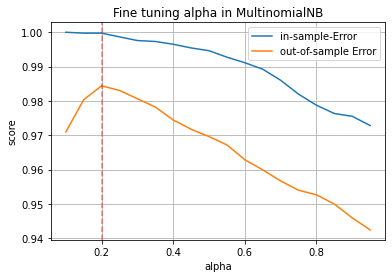

In [12]:
plt.plot(alphas, train_score, label="in-sample-Error")
plt.plot(alphas, validation_score, label='out-of-sample Error')
plt.legend()
plt.title("Fine tuning alpha in MultinomialNB")
plt.xlabel("alpha")
plt.ylabel("score")
plt.axvline(x = alphas[np.argmax(validation_score)],color = 'red', linestyle = '--', alpha = 0.5)
plt.grid()
print("max at ", max(validation_score))

In [13]:
alphas[np.argmax(validation_score)]

0.20000000000000004

In [14]:
model=MultinomialNB(alpha=alphas[np.argmax(validation_score)] )
model.fit(X_train, y_train)
y_model=model.predict(X_test)

In [15]:
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay, DetCurveDisplay
roc_auc_score(y_test, y_model, multi_class="ovr")

0.9516689994486152

In [16]:
from sklearn import metrics
#fpr, tpr, thresholds = roc_curve(y_test, y_model)
#roc_auc = metrics.auc(fpr, tpr)
#display = RocCurveDisplay(fpr=fpr, tpr=tpr,roc_auc=roc_auc,estimator_name='example estimator')
#display.plot()
#plt.show()

#roc_curve;

One tool that is possible to use is the **ROC-curve**, a curve that describe the True Positive Rate (TPR) vs False Positive Rate (FPR) for a grid of different values of threshold applied on the **classifier output distribution**, the distribution in output from the model. Its area is called **ROC-AUC**:  a score close to 1 means a good true positive rate and a good false positve rate. The wrost score is 0.5.

Text(0.5, 1.0, 'Receiver Operating Characteristic (ROC) curves')

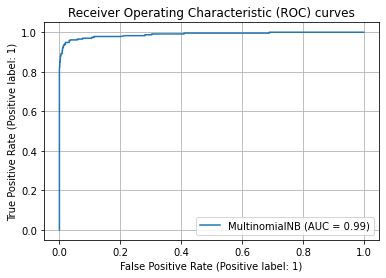

In [17]:
metrics.plot_roc_curve(model, X_test, y_test,  sample_weight=None, drop_intermediate=True, response_method='predict_proba', name=None, ax=None, pos_label=None )
plt.grid()
plt.title("Receiver Operating Characteristic (ROC) curves")

Once that I tested MultinomialNB I want to try other models in order to see their performance on the training set.
Let's start with Random Forest and Logistic Regression!

In [18]:
from sklearn.ensemble import RandomForestClassifier
#n_trees=np.arange(25,200,25)
#score_tr=[]
#score_val_tr=[]
#for n_tr in n_trees:
#    model2=RandomForestClassifier(n_estimators=n_tr)
#    model2.fit(X_train, y_train)
#    score_tr.append(model2.score(X_train,y_train))
#    val_score=cross_val_score(model2, X_train, y_train, cv=5)
#    score_val_tr.append(np.mean(val_score))

In [19]:
#plt.plot(n_trees, score_tr, label="in-sample-error RM")
#plt.plot(n_trees, score_val_tr, label="out-of-sample-error RM")
#plt.xlabel("Number of trees")
#plt.ylabel("score")
#plt.legend()
#plt.grid()
#plt.ylim(0.9,1.1)
#print("max at ",n_trees[np.argmax(score_val_tr)], "with score ", max(score_val_tr))

In [20]:
#model2=RandomForestClassifier(n_estimators=n_trees[np.argmax(score_val_tr)])
model2=RandomForestClassifier(n_estimators=50)
model2.fit(X_train,y_train)
from sklearn.linear_model import LogisticRegression
model3=LogisticRegression()
model3.fit(X_train, y_train)
model3.score(X_test, y_test)

0.9316469321851453

Let's try Perceptron algorithm!

In [21]:
from sklearn.linear_model import Perceptron
model4= Perceptron()
model4.fit(X_train, y_train)
scores=cross_val_score(model4, X_train, y_train, cv=5)
print("Perceptron score: ",np.mean(scores))

Perceptron score:  0.9728208801863992


Here the comparison with all the different models!

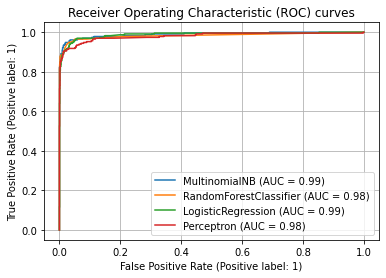

In [22]:
ax_roc=plt.subplot(1,1,1)
ax_roc.grid()
ax_roc.set_title("Receiver Operating Characteristic (ROC) curves")
metrics.plot_roc_curve(model,  X_test, y_test,  sample_weight=None, drop_intermediate=True, response_method='predict_proba', name=None, ax=ax_roc, pos_label=None )
metrics.plot_roc_curve(model2, X_test, y_test,  sample_weight=None, drop_intermediate=True, response_method='predict_proba', name=None, ax=ax_roc, pos_label=None )
metrics.plot_roc_curve(model3, X_test, y_test,  sample_weight=None, drop_intermediate=True, response_method='predict_proba', name=None, ax=ax_roc, pos_label=None )
metrics.plot_roc_curve(model4, X_test, y_test,  sample_weight=None, drop_intermediate=True,response_method='decision_function', name=None, ax=ax_roc, pos_label=None )

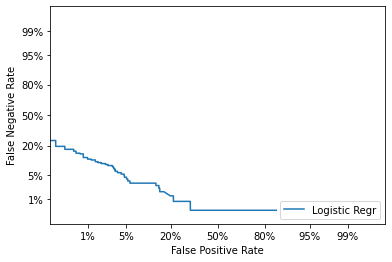

In [23]:
fpr, fnr, _= metrics.det_curve(y_test, model3.decision_function(X_test))
display=metrics.DetCurveDisplay(fpr=fpr, fnr=fnr,estimator_name="Logistic Regr")
display.plot()

In [24]:
print("model Multinomial NB     score:", model.score(X_test, y_test))
print("model RandomForest       score:", model2.score(X_test, y_test))
print("model LogisticRegression score:", model3.score(X_test, y_test))
print("model Peceptron score:", model4.score(X_test, y_test))

model Multinomial NB     score: 0.9800861141011841
model RandomForest       score: 0.9682454251883746
model LogisticRegression score: 0.9316469321851453
model Peceptron score: 0.9752421959095802


In [25]:
 model3.decision_function(X_test);

In [26]:
model3.predict_proba(X_test);

# Final model: Multinomial Naive-Bayes
As a final model I will use Multinomial NB due to its performance. I will evaluate the model on the test set and I will print which message is considered SPAM for the model! 

In [27]:
array=model.predict(X_test)
model.score(X_test, y_test)

0.9800861141011841

In [28]:
dic=cv.vocabulary_
text=messages[5400:]
truth= y[5400:]
dic;

In [29]:
cv2=CountVectorizer(token_pattern=pattern, vocabulary=dic, stop_words=stop_words, ngram_range=(1,2), )
C=cv2.fit_transform(text)
tfidf= TfidfTransformer()
X= tfidf.fit_transform(C)

In [30]:
cv2.fixed_vocabulary_

True

In [31]:
X

<174x32407 sparse matrix of type '<class 'numpy.float64'>'
	with 2051 stored elements in Compressed Sparse Row format>

In [32]:
modelF= model=MultinomialNB(alpha=0.2)
modelF.fit(X_train, y_train)
solutions=modelF.predict(X)

In [33]:
solutions.size

174

In [34]:
for i in range(solutions.size):
    if solutions[i]==1:
        print(truth[i],  "\x1b[31m\"","SPAM: ","\x1b[0m", text[i])

1 " SPAM:   Santa Calling! Would your little ones like a call from Santa Xmas eve? Call 09058094583 to book your time.

1 " SPAM:   You have won a guaranteed 32000 award or maybe even £1000 cash to claim ur award call free on 0800 ..... (18+). Its a legitimat efreefone number wat do u think???

1 " SPAM:   Latest News! Police station toilet stolen, cops have nothing to go on!

1 " SPAM:   "For the most sparkling shopping breaks from 45 per person; call 0121 2025050 or visit www.shortbreaks.org.uk"

1 " SPAM:   December only! Had your mobile 11mths+? You are entitled to update to the latest colour camera mobile for Free! Call The Mobile Update Co FREE on 08002986906

1 " SPAM:   Txt: CALL to No: 86888 & claim your reward of 3 hours talk time to use from your phone now! Subscribe6GBP/mnth inc 3hrs 16 stop?txtStop www.gamb.tv

1 " SPAM:   http//tms. widelive.com/index. wml?id=820554ad0a1705572711&first=true¡C C Ringtone¡

1 " SPAM:   Get your garden ready for summer with a FREE selection 

In [35]:
roc_auc_score(truth, solutions)

1.0